# Zadatak 1
## Marko Šišović, 2024/3104

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

Učitajmo najpre podatke iz .csv datoteke. Podelićemo date podatke na matricu $x$, koja predstavlja matricu prediktora, kao i vektor $y$, koji predstavlja vektor ciljne promenljive. Dodatno, nasumično ćemo promešati date podatke, kao i podeliti ih na trening i test skup, u odnosu $80:20$. Na kraju koda ispisujemo dimenzionalnosti prethodno pomenutih elemenata, kako bismo se uverili u njihovo poklapanje.

In [82]:
data = np.loadtxt("../data-reg.csv", delimiter=",")
x, y = data[:, :-1], data[:, -1]

split_ratio = 0.8

split_index = int(len(x) * split_ratio)

indices = np.random.permutation(len(x))
x, y = x[indices], y[indices]

x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(273, 5) (273,) (69, 5) (69,)


Pošto je zbir cifara indeksa $S = 3 + 1 + 0 + 4 = 8$, pa je $S\mod 3 = 8 \mod 3 = 2$, i stoga rešavamo problem korišćenjem lokalno ponderisane linearne regresije. Kako bismo nasli parametre $\theta$ za svaki uzorak koristićemo istu formulu kao i kod obične linearne regresije, samo što ćemo umesto matrice $X$ i vektora $y$, koristiti elemente korigovane odgovarajućim težinama, $X_w$ i $y_w$.

Hiperparametar $\tau$ biramo pomoću unakrsne validacije. Parametar $k$ za unakrsnu validaciju iznosi $5%.

In [ ]:
def calculate_weight(x_star, x, tau):
    return np.exp(-np.linalg.norm(x_star - x)**2/(2*tau**2))

def estimate_y(x_star, tau, x, y):
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = (x - x_mean)/x_std
    x_star = (x_star - x_mean)/x_std
    y = y[:, np.newaxis]

    w = np.apply_along_axis(lambda row: calculate_weight(x_star, row, tau), axis = 1, arr = x)
    w = w[:, np.newaxis]
    xw, yw = x*w, y*w

    theta = np.linalg.inv(xw.T@xw)@xw.T@yw

    y_est = theta.T@x_star
    return y_est

def estimate_error(tau, k = 5):
    fold_size = len(x_train) // k
    err_vector = np.array([])
    for fold in range(k):
        val_start = fold * fold_size
        val_end = val_start + fold_size if fold < k - 1 else len(x_train)
        
        x_val_fold = x_train[val_start:val_end]
        y_val_fold = y_train[val_start:val_end]
        
        x_train_fold = np.concatenate((x_train[:val_start], x_train[val_end:]), axis=0)
        y_train_fold = np.concatenate((y_train[:val_start], y_train[val_end:]), axis=0)
        
        y_val_fold_est = np.apply_along_axis(lambda row: estimate_y(row, tau, x_train_fold, y_train_fold), axis = 1, arr = x_val_fold)
        err = np.linalg.norm(y_val_fold_est - y_val_fold[:, np.newaxis])**2
        err_vector = np.append(err_vector, err)
    return np.mean(err_vector)

tau_arr = np.linspace(0.5, 3.5, 30)
estimate_error_vectorized = np.vectorize(lambda tau: estimate_error(tau))
err_arr = estimate_error_vectorized(tau_arr)

In [106]:
min_index = np.argmin(err_arr)
tau_opt = tau_arr[min_index]
err_opt = err_arr[min_index]
print("Optimalna vrednost parametra tau:", tau_opt, sep = ' ')

Optimalna vrednost parametra tau: 2.2586206896551726


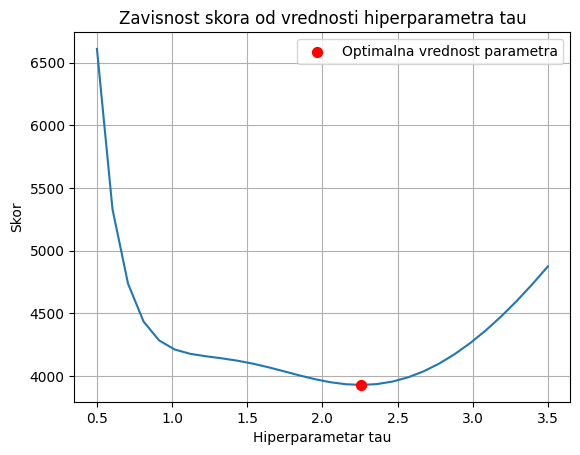

In [112]:
plt.plot(tau_arr, err_arr)

plt.xlabel('Hiperparametar tau')
plt.ylabel('Skor')
plt.title('Zavisnost skora od vrednosti hiperparametra tau')

plt.scatter(tau_opt, err_opt, color='red', s=50, label=f"Optimalna vrednost parametra", zorder=5)

plt.grid(True)

plt.legend()
plt.show()

Na grafiku iznad možemo videti kako se menja skor određen pomoću unakrsne validacije sa promenom hiperparametra. Očitavamo optimalnu vrednost za hiperparametar $\tau = 2.2586206896551726$.

In [111]:
estimate_error(tau_opt)

np.float64(3928.424432154627)